In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [0]:
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
tf.set_random_seed(777)

In [0]:
# 데이터 전처리
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

In [0]:
# 데이터 전처리
# 너무 작거나 너무 큰 값은 학습에 방해되므로 정규화
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# 0으로 나누는 오류 방지차원에서 분자에 1e-7 더해줌
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7)

In [0]:
# 데이터 전처리
# 역정규화_정규화 이전의 값으로 되돌림
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [0]:
input_data_column_cnt = 13  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 35            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 4     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [0]:
currency_file_name = 'JPY_KRW_08_23.csv' # 환율 데이타셋
encoding = 'euc-kr' # 문자 인코딩
names = ['date','EUR-OPEN','EUR-HIGH','EUR-LOW', 'USD-OPEN','USD-HIGH','USD-LOW','GBP-OPEN','GBP-HIGH','GBP-LOW','JPY-OPEN','JPY-HIGH','JPY-LOW', 'JPY']
raw_dataframe = pd.read_csv(currency_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

del raw_dataframe['date'] # 시간열을 제거하고 dataframe 재생성하지 않기
 
currency_info = raw_dataframe.values[1:].astype(np.float) # 
print("currency_info.shape: ", currency_info.shape)
print("currency_info[0]: ", currency_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5683 entries, 0 to 5682
Data columns (total 14 columns):
date        5683 non-null object
EUR-OPEN    5683 non-null object
EUR-HIGH    5683 non-null object
EUR-LOW     5683 non-null object
USD-OPEN    5683 non-null object
USD-HIGH    5683 non-null object
USD-LOW     5683 non-null object
GBP-OPEN    5683 non-null object
GBP-HIGH    5683 non-null object
GBP-LOW     5683 non-null object
JPY-OPEN    5683 non-null object
JPY-HIGH    5683 non-null object
JPY-LOW     5683 non-null object
JPY         5683 non-null object
dtypes: object(14)
memory usage: 621.7+ KB
currency_info.shape:  (5682, 13)
currency_info[0]:  [1096.99   1103.15   1096.99    969.5     971.      969.5    1610.4
 1636.87   1609.92      8.0108    8.1045    7.937     7.9938]


In [0]:
# 환율 정보_1 (OPEN-HIGH-LOW)
parameter_1 = currency_info[:, :3]
norm_parameter_1 = min_max_scaling(parameter_1) 
print("parameter_1.shape: ", parameter_1.shape)
print("parameter_1[0]: ", parameter_1[0])
print("norm_parameter_1[0]: ", norm_parameter_1[0])
print("="*100) 

# 환율 정보_2 (OPEN-HIGH-LOW)
parameter_2 = currency_info[:, 3:6]
norm_parameter_2 = min_max_scaling(parameter_2) 
print("parameter_2.shape: ", parameter_2.shape)
print("parameter_2[0]: ", parameter_2[0])
print("norm_parameter_2[0]: ", norm_parameter_2[0])
print("="*100)

# 환율 정보_3 (OPEN-HIGH-LOW)
parameter_3 = currency_info[:, 6:9]
norm_parameter_3 = min_max_scaling(parameter_3) 
print("parameter_3.shape: ", parameter_3.shape)
print("parameter_3[0]: ", parameter_3[0])
print("norm_parameter_3[0]: ", norm_parameter_3[0])
print("="*100)

# 타겟 환율 정보_4 (OPEN-HIGH-LOW)
target_price = currency_info[:, 9:-1]
norm_target_price = min_max_scaling(target_price) 
print("target_price.shape: ", target_price.shape)
print("target_price[0]: ", target_price[0])
print("norm_target_price[0]: ", norm_target_price[0])
print("="*100)

# 타겟 (CLOSE 환율의 종가_ 다음날 오픈가)
result = currency_info[:,-1:]
norm_result = min_max_scaling(result) 
print("result.shape: ", result.shape)
print("result[0]: ", result[0])
print("norm_result[0]: ", norm_result[0])
print("="*100)

x = np.concatenate((norm_parameter_1, norm_parameter_2, norm_parameter_3, norm_target_price, norm_result), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) 
 
y = x[:, [-1]]

print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

parameter_1.shape:  (5682, 3)
parameter_1[0]:  [1096.99 1103.15 1096.99]
norm_parameter_1[0]:  [0.13534313 0.1402456  0.13534313]
parameter_2.shape:  (5682, 3)
parameter_2[0]:  [969.5 971.  969.5]
norm_parameter_2[0]:  [0.06389776 0.065267   0.06389776]
parameter_3.shape:  (5682, 3)
parameter_3[0]:  [1610.4  1636.87 1609.92]
norm_parameter_3[0]:  [0.1465763  0.15981594 0.14633622]
target_price.shape:  (5682, 3)
target_price[0]:  [8.0108 8.1045 7.937 ]
norm_target_price[0]:  [0.0640474  0.07446442 0.05584275]
result.shape:  (5682, 1)
result[0]:  [7.9938]
norm_result[0]:  [0.06072038]
x.shape:  (5682, 13)
x[0]:  [0.13534313 0.1402456  0.13534313 0.06389776 0.065267   0.06389776
 0.1465763  0.15981594 0.14633622 0.0640474  0.07446442 0.05584275
 0.06072038]
x[-1]:  [0.32305354 0.33180794 0.32594249 0.27657691 0.28545869 0.27657691
 0.07051968 0.08450458 0.07018456 0.42719763 0.44107216 0.42708646
 0.44232354]
y[0]:  [0.06072038]
y[-1]:  [0.44232354]


In [0]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 환율
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[0.13534313 0.1402456  0.13534313 0.06389776 0.065267   0.06389776
  0.1465763  0.15981594 0.14633622 0.0640474  0.07446442 0.05584275
  0.06072038]
 [0.13421302 0.13824005 0.13421302 0.06800548 0.06809676 0.04974897
  0.15088781 0.15882059 0.13747312 0.0617461  0.06758274 0.03745456
  0.04716672]
 [0.14580067 0.14984361 0.14580067 0.0616157  0.06782291 0.0616157
  0.14741159 0.16090632 0.14477567 0.05157367 0.06291343 0.04068972
  0.04794606]
 [0.15132391 0.15180142 0.15132391 0.06353263 0.069466   0.06353263
  0.15305857 0.16806382 0.15185315 0.04892773 0.05883334 0.04638184
  0.05141353]
 [0.15884474 0.16382679 0.15884474 0.07348243 0.07841168 0.07348243
  0.1651478  0.17626669 0.16310709 0.05242971 0.06348042 0.04479205
  0.04797994]
 [0.17889233 0.18093768 0.17889233 0.07530808 0.09274304 0.07530808
  0.16262692 0.18873606 0.16038113 0.05371933 0.07289686 0.04856085
  0.06309227]
 [0.16811645 0.17350439 0.16811645 0.09164765 0.09164765 0.07804655
  0.18554994 0.19438804 0.1742409

In [0]:
# 전체 데이타셋 중 70% 훈련용 데이터로 사용 
train_size = int(len(dataY) * 0.70) 

# 나머지(30%)를 테스트용 데이터로 사용 
test_size = len(dataY) - train_size 

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [0]:
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)
 
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 35, 13), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [0]:
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

#num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

#LSTM셀들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)
 
# LSTM RNN의 마지막 (hidden)출력만을 사용 => hypothesis[:, -1]
# 과거의 환율 데이터셋을 이용해서 다음날의 환율 1개를 예측 => MANY-TO-ONE형태
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

W0826 05:11:58.095491 140005362091904 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0826 05:11:58.096889 140005362091904 deprecation.py:323] From <ipython-input-12-da9a0a0ec41b>:9: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0826 05:11:58.099908 140005362091904 deprecation.py:323] From <ipython-input-12-da9a0a0ec41b>:16: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instruction

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 35, 20), dtype=float32)


In [0]:
# 손실함수_ 평균제곱오차
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수_ AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [0]:
train_error_summary = [] # 학습용 데이터 오류 기록
test_error_summary = []  # 테스트용 데이터 오류 기록
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# 학습
start_time = datetime.datetime.now() # 시작시간을 기록
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # rmse오차 (학습용데이터)
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # rmse오차 (테스트용데이터)
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류 출력
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.032666873186826706, test_error(B): 0.03121050074696541, B-A: -0.0014563724398612976
epoch: 200, train_error(A): 0.028806272894144058, test_error(B): 0.02344428561627865, B-A: -0.00536198727786541
epoch: 300, train_error(A): 0.025645267218351364, test_error(B): 0.017000816762447357, B-A: -0.008644450455904007
epoch: 400, train_error(A): 0.022946540266275406, test_error(B): 0.013964736834168434, B-A: -0.008981803432106972
epoch: 500, train_error(A): 0.02087000571191311, test_error(B): 0.016360877081751823, B-A: -0.004509128630161285
epoch: 600, train_error(A): 0.01661701314151287, test_error(B): 0.0112546281889081, B-A: -0.005362384952604771
epoch: 700, train_error(A): 0.01609085313975811, test_error(B): 0.010443389415740967, B-A: -0.005647463724017143
epoch: 800, train_error(A): 0.01540670171380043, test_error(B): 0.009934207424521446, B-A: -0.005472494289278984
epoch: 900, train_error(A): 0.015519610606133938, test_error(B): 0.0111348722130060

input_data_column_cnt: 13output_data_column_cnt: 1seq_length: 35rnn_cell_hidden_dim: 20forget_bias: 1.0num_stacked_layers: 4keep_prob: 1.0epoch_num: 1000learning_rate: 0.01train_error: 0.014830274test_error: 0.009699345min_test_error: 0.009699345


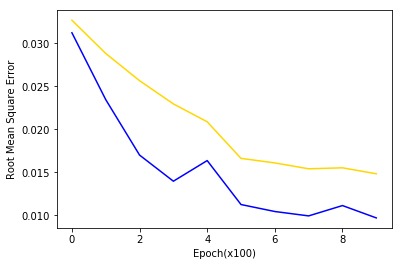

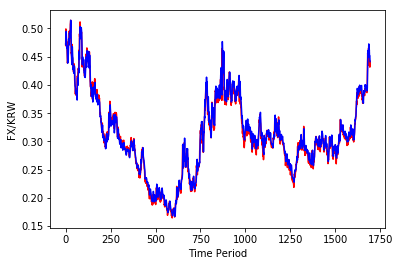

In [0]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print('output_data_column_cnt:', output_data_column_cnt, end='')
print('seq_length:', seq_length, end='')
print('rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print('forget_bias:', forget_bias, end='')
print('num_stacked_layers:', num_stacked_layers, end='')
print('keep_prob:', keep_prob, end='')
print('epoch_num:', epoch_num, end='')
print('learning_rate:', learning_rate, end='')
print('train_error:', train_error_summary[-1], end='')
print('test_error:', test_error_summary[-1], end='')
print('min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('FX/KRW')
plt.show()

In [0]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 환율을 예측
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(target_price,test_predict) # target_price 역정규화
print()
print("19.08.23 FX/KRW Prediction", test_predict[0]) # 예측 환율을 출력

recent_data.shape: (1, 35, 13)
recent_data: [[[0.31119529 0.31425934 0.30883956 0.24488361 0.25210406 0.24430853
   0.07573651 0.07855249 0.07383584 0.37759174 0.38111596 0.37332266
   0.38141116]
  [0.31232541 0.31932893 0.31185585 0.2519215  0.2588042  0.25148334
   0.07718702 0.08252889 0.07683189 0.37862566 0.387653   0.37706922
   0.38464144]
  [0.31643998 0.31893897 0.31425138 0.25688727 0.26076677 0.25480602
   0.08026309 0.08097334 0.07681188 0.38099367 0.38422884 0.37735828
   0.38554502]
  [0.31772927 0.31912997 0.31474481 0.25898676 0.25920584 0.25202191
   0.07888761 0.07967789 0.07594658 0.38178301 0.38218323 0.37698028
   0.3830376 ]
  [0.31572371 0.3188753  0.31289047 0.25291648 0.25497033 0.24749429
   0.07673686 0.0797279  0.07484119 0.37951505 0.38580751 0.37660229
   0.38123044]
  [0.31492786 0.32160508 0.31379774 0.25162939 0.25675034 0.25075308
   0.07688691 0.0825589  0.07623168 0.37764733 0.38850904 0.37624654
   0.39017585]
  [0.3180874  0.32291824 0.31770539 0.